In [1]:
%%capture
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Dataset

In [2]:
df = pd.read_csv('balanced_dataset.csv')
df.head()

,class,tweet
0,0,queer gaywad
1,0,alsarabsss hes beaner smh tell hes mexican
2,0,youre fucking gay blacklisted hoe holding tehg...
3,0,lmfaoooo hate black people theres black people...
4,0,least im nigger lmfao


## Split Data

In [3]:
features = df['tweet']
target = df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features,
												target,
												test_size=0.2,
												random_state=22)
X_train.shape, X_val.shape

# make labels categorical
Y_train = to_categorical(Y_train, num_classes=3)
Y_val = to_categorical(Y_val, num_classes=3)

## Tokenization

In [4]:
with open('tokenizer.pkl', 'rb') as handle:
    token = pickle.load(handle)

In [5]:
# generating token embeddings
max_words = 5000
max_len = 100

X_train_seq = token.texts_to_sequences(X_train)
X_val_seq = token.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len)

## Model

In [6]:
model = keras.models.Sequential([
	layers.Embedding(max_words, 32, input_length=max_len),

	# LSTM
	layers.Bidirectional(layers.LSTM(64)),

	layers.Dense(512, activation='relu', kernel_regularizer='l1'),
	layers.BatchNormalization(),
	layers.Dropout(0.3),
	layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
			optimizer='adam',
			metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

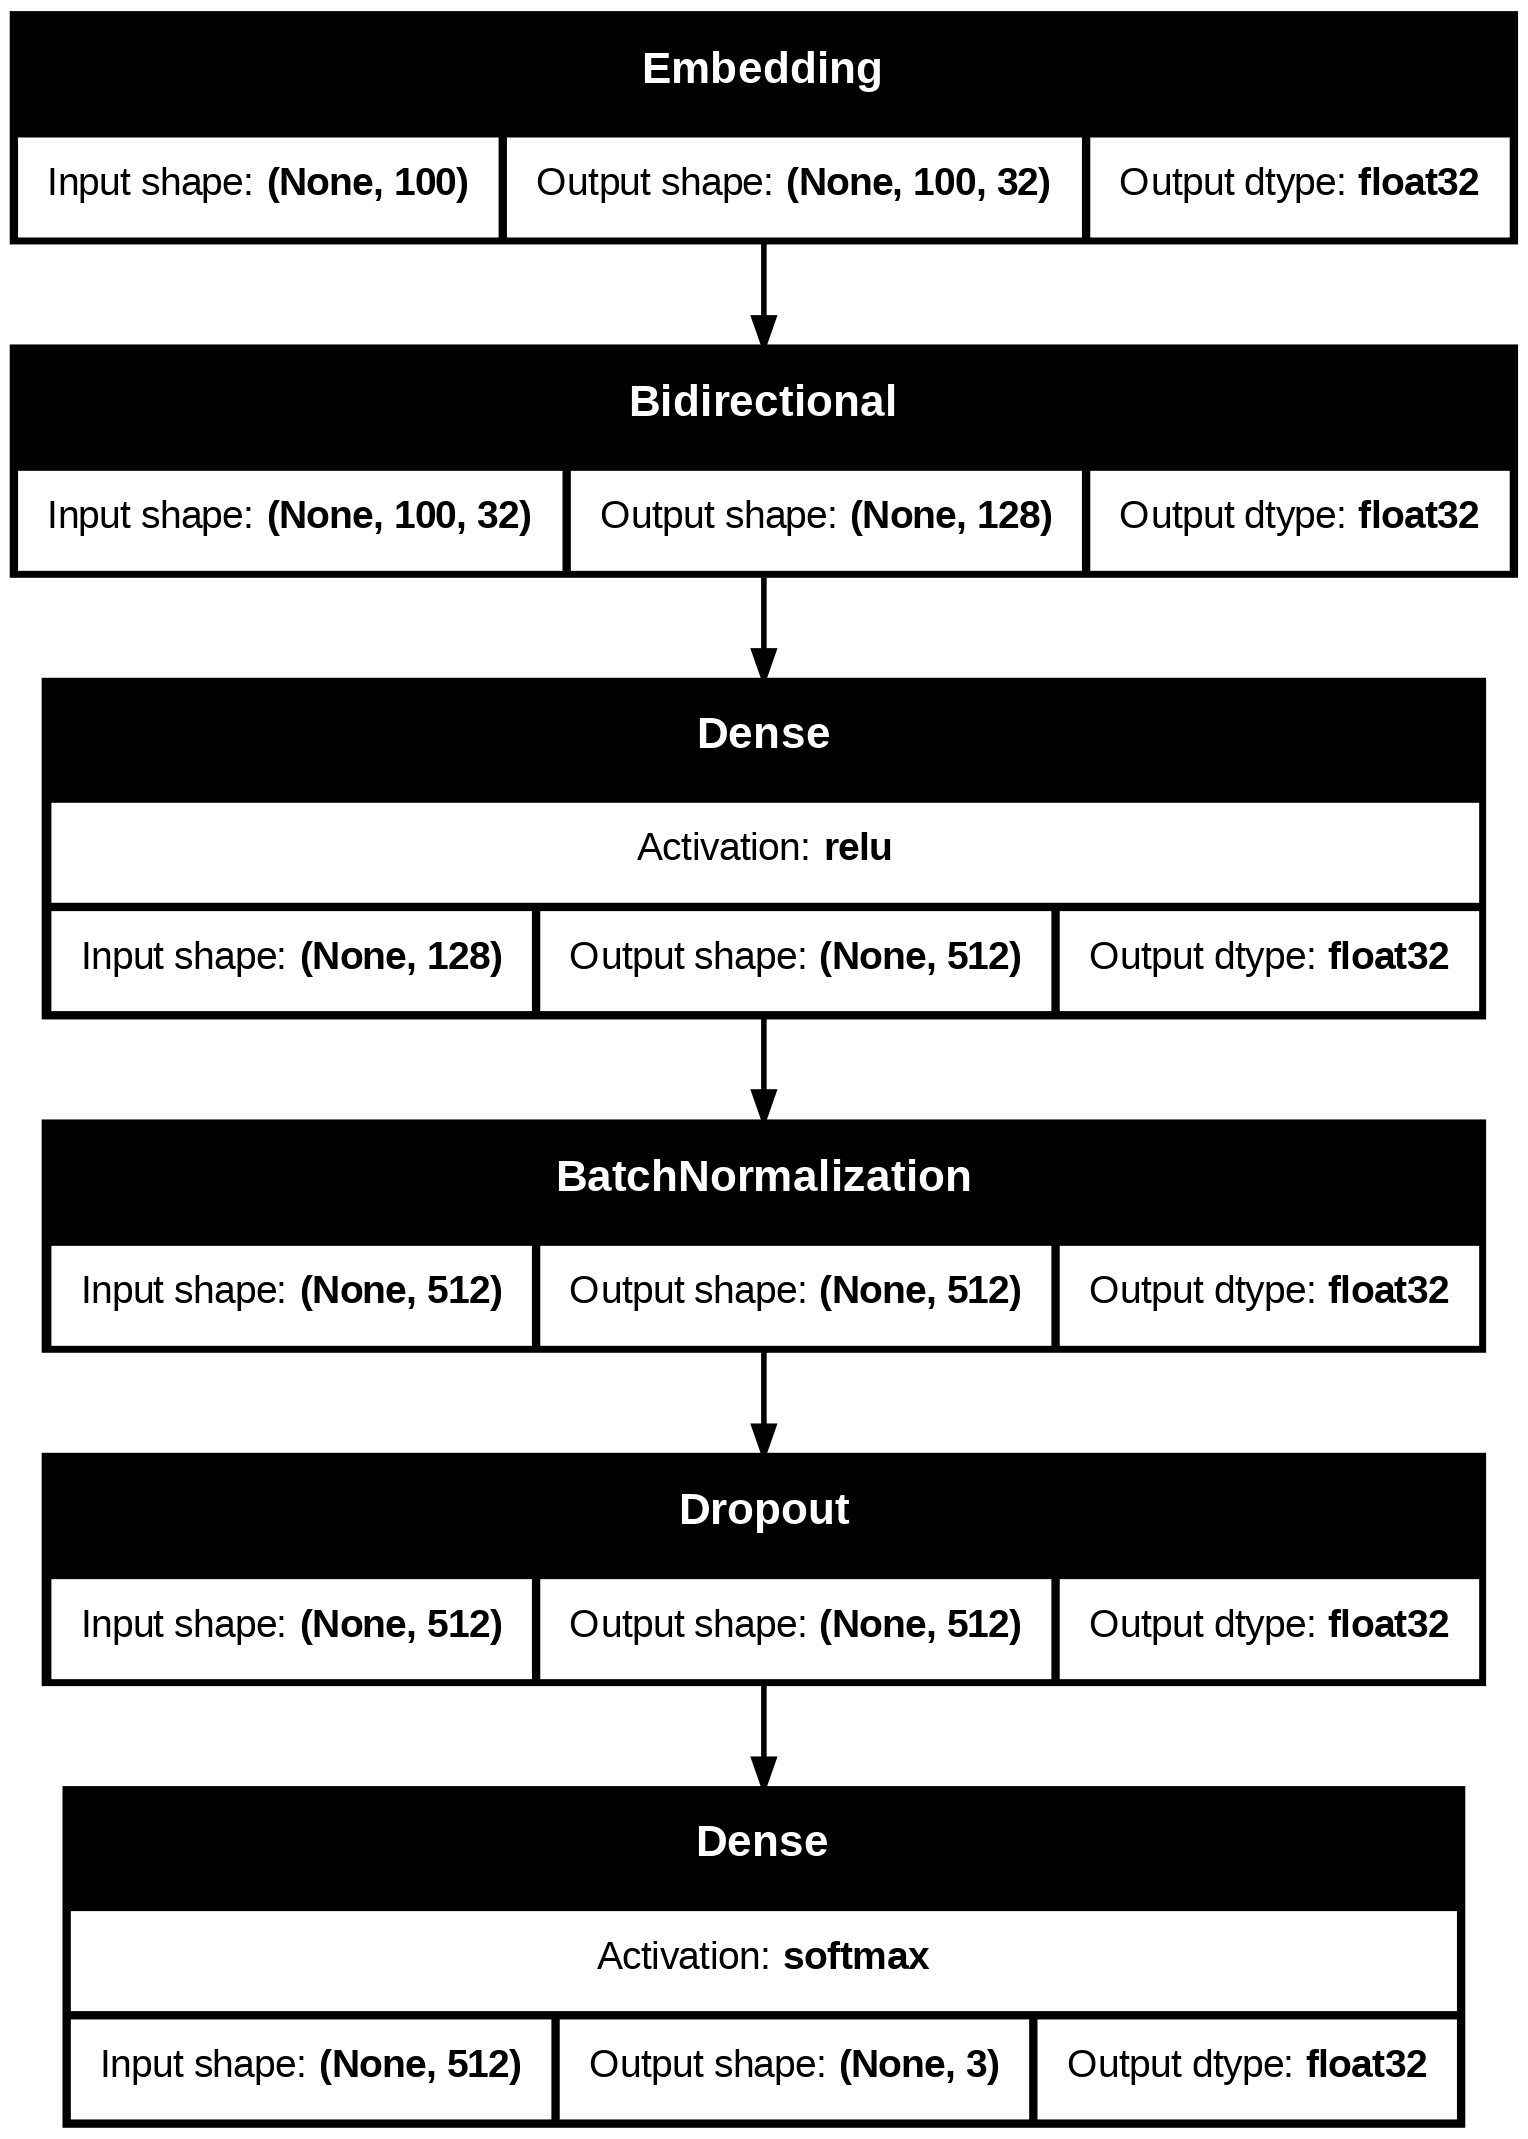

In [7]:
# Add a dummy input to build the model
model.build((None, max_len))

keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

In [8]:
lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)

In [9]:
# custom callback to calculate precision, recall, and F1-score
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_predictions = np.argmax(self.model.predict(X_val_padded), axis=1)
        val_true = np.argmax(Y_val, axis=1)

        precision = precision_score(val_true, val_predictions, average='weighted')
        recall = recall_score(val_true, val_predictions, average='weighted')
        f1 = f1_score(val_true, val_predictions, average='weighted')

        print(f" - val_precision: {precision:.4f} - val_recall: {recall:.4f} - val_f1_score: {f1:.4f}")
        logs.update({'val_precision': precision, 'val_recall': recall, 'val_f1_score': f1})

In [10]:
metrics_callback = MetricsCallback()

history = model.fit(X_train_padded, Y_train,
					validation_data=(X_val_padded, Y_val),
					epochs=50,
					verbose=1,
					batch_size=32,
					callbacks=[lr, metrics_callback])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
 - val_precision: 0.8411 - val_recall: 0.8419 - val_f1_score: 0.8408
299/299 ━━━━━━━━━━━━━━━━━━━━ 42s 123ms/step - accuracy: 0.6526 - loss: 11.2840 - val_accuracy: 0.8419 - val_loss: 1.0106 - learning_rate: 0.0010 - val_precision: 0.8411 - val_recall: 0.8419 - val_f1_score: 0.8408
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
 - val_precision: 0.8574 - val_recall: 0.8524 - val_f1_score: 0.8508
299/299 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.8942 - loss: 0.4813 - val_accuracy: 0.8524 - val_loss: 0.5680 - learning_rate: 0.0010 - val_precision: 0.8574 - val_recall: 0.8524 - val_f1_score: 0.8508
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
 - val_precision: 0.8533 - val_recall: 0.8494 - val_f1_score: 0.8482
299/299 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.9359 - loss: 0.3453 - val_accuracy: 0.8494 - val_loss: 0.5400 - learning_rate: 0.0010 - val_precision: 0.8533 - val_recall: 0.8494 - val_f1_score: 0.8482
Epo

## Visualize Model Results

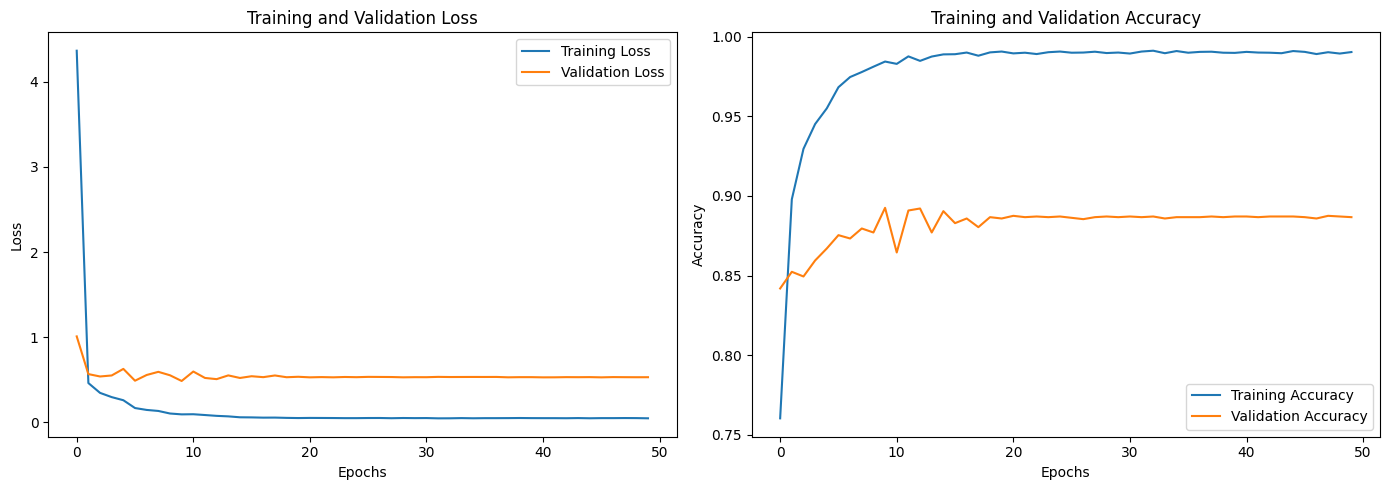

In [11]:
history_df = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot loss
history_df.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend(['Training Loss', 'Validation Loss'])

# plot accuracy
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])

plt.tight_layout()
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


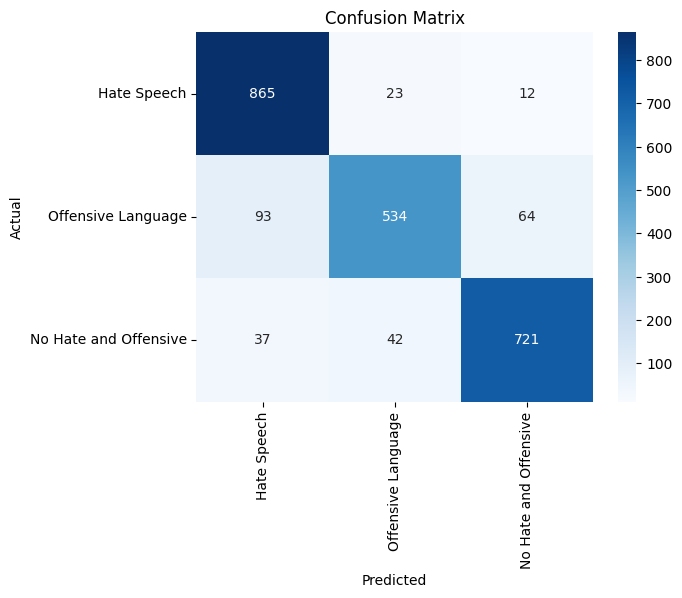

In [12]:
pred = model.predict(X_val_padded)
pred_class = np.argmax(pred, axis=1)

# plot the confusion matrix
Y_val_class = np.argmax(Y_val, axis=1)
conf_matrix = confusion_matrix(Y_val_class, pred_class)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate Speech', 'Offensive Language', 'No Hate and Offensive'],
            yticklabels=['Hate Speech', 'Offensive Language', 'No Hate and Offensive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
print("Classification Report:\n")
print(classification_report(Y_val_class, pred_class))

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       900
           1       0.89      0.77      0.83       691
           2       0.90      0.90      0.90       800

    accuracy                           0.89      2391
   macro avg       0.89      0.88      0.88      2391
weighted avg       0.89      0.89      0.89      2391



In [14]:
# look at the misclassified tweets

pred_df = pd.DataFrame(pred_class, columns=['pred_class'])
pred_df['actual_class'] = np.argmax(Y_val, axis=1)
pred_df['tweet'] = X_val.values

misclassified_tweets = pred_df[pred_df['pred_class'] != pred_df['actual_class']]
misclassified_tweets.head()

,pred_class,actual_class,tweet
11,2,1,release nudes cunt
54,0,2,im biggest redskins dam right get stop
60,2,0,washing coon hair
71,0,1,never trust nicca volunteers another man info
76,0,1,niggas expect pull ask hoes


## Save Model

In [15]:
model.save('rnn_w_LSTM.keras')